#***IMAGE CLASSICATION OF FRUITS USING CNN***






This Notebook is an attempt to classify images of fruits using convolutional neural network and to attain the maximum accuracy with the prediction.

In [1]:
!pip install jovian --upgrade --quiet

##**DATASET DOWNLOADING**

First we have to download the dataset from kagle using opendataset module.

In [2]:
!pip install opendatasets --upgrade --quiet

In [ ]:
import opendatasets as od

In [ ]:
od.download('https://www.kaggle.com/moltean/fruits')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: akashdominicthomas
Your Kaggle Key: ··········


  2%|▏         | 18.0M/760M [00:00<00:04, 187MB/s]

100%|██████████| 760M/760M [00:05<00:00, 158MB/s]


In [ ]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [ ]:
data_dir="/content/fruits/fruits-360"

In [ ]:
print(os.listdir(data_dir))

['test-multiple_fruits', 'LICENSE', 'readme.md', 'Test', 'papers', 'Training']


In [ ]:
classes = os.listdir(data_dir + "/Training")


**Q**. What is the number of classes and its names?

In [ ]:
len(classes)

131

In [ ]:
print(classes)

['Maracuja', 'Strawberry', 'Tomato 1', 'Apple Red Delicious', 'Mulberry', 'Apple Golden 3', 'Kumquats', 'Lychee', 'Onion Red', 'Apple Braeburn', 'Raspberry', 'Pomelo Sweetie', 'Mandarine', 'Apple Red 1', 'Cucumber Ripe 2', 'Pepper Orange', 'Grape White 3', 'Grape White 2', 'Pear Stone', 'Apple Golden 2', 'Apple Pink Lady', 'Cherry Rainier', 'Limes', 'Watermelon', 'Tomato not Ripened', 'Orange', 'Ginger Root', 'Beetroot', 'Plum 3', 'Peach Flat', 'Passion Fruit', 'Chestnut', 'Tangelo', 'Pineapple', 'Banana Lady Finger', 'Papaya', 'Pear Red', 'Potato Red', 'Huckleberry', 'Tomato 4', 'Cocos', 'Lemon', 'Hazelnut', 'Nut Forest', 'Pear', 'Grape White', 'Apricot', 'Quince', 'Pomegranate', 'Mango', 'Apple Red Yellow 2', 'Pear Kaiser', 'Pear Monster', 'Peach 2', 'Mango Red', 'Tomato 3', 'Cherry Wax Yellow', 'Plum', 'Avocado', 'Strawberry Wedge', 'Apple Crimson Snow', 'Walnut', 'Pitahaya Red', 'Grapefruit Pink', 'Potato Sweet', 'Melon Piel de Sapo', 'Potato Red Washed', 'Avocado ripe', 'Dates', '

##DATASET PREPARATION

Now lets prepare the datasets using **image** class in **pytorch**.In addition to the **ToTensor transform**, we will use **data augmentation** and **normalization** to tackle overfitting and improve accuracy.

In [ ]:
# Data transforms (normalization & data augmentation)
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_tfms = tt.Compose([tt.RandomCrop(100, padding=4, padding_mode='reflect'), 
                         tt.RandomHorizontalFlip(), 
                          tt.RandomRotate
                          tt.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)), 
                          tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                         tt.ToTensor(), 
                         tt.Normalize(*stats,inplace=True)])
valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

In [ ]:
train_ds = ImageFolder(data_dir+'/Training', train_tfms)
valid_ds = ImageFolder(data_dir+'/Test', valid_tfms)

**Q.** How much data is available for validation and training?

In [ ]:
len(valid_ds)

22688

In [ ]:
len(train_ds)

67692

In [ ]:
batch_size = 300

In [ ]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=3, pin_memory=True)

Let's take a look at some sample images from the training dataloader. To display the images, we'll need to denormalize the pixels values to bring them back into the range (0,1).

In [ ]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

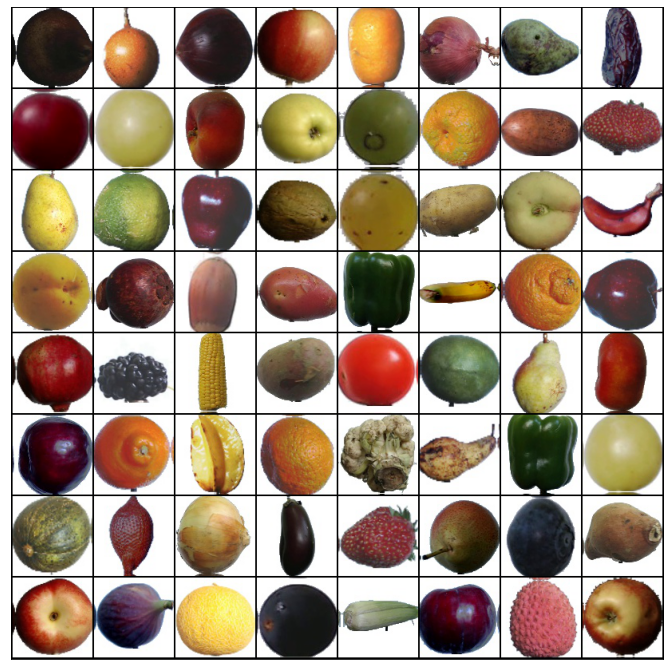

In [ ]:
show_batch(train_dl)

## **MOVING DATA TO GPU**

Now we need to move the data to gpu for faster training as we are dealing with a large dataset.

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

##**MODEL PREPARATION**

Now lets make the model , here we are going to use four convolutional layers , two residual layers ,three maxpool layers and one linear layer.We need to extend ImageClassificationBase and ResNet9 class.

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(25), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

Now lets see the model in detail.

In [ ]:
model = to_device(ResNet9(3, 131), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

##**TRAINING OF THE MODEL**

Now lets train the model by defining the fit function with minor modification to make our model more powerful using techniques like gradient clipping,learning rate scheduling and weight decay.

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

Now lets use the model on validation dataset to check the loss and accuracy and loss before training.

In [ ]:
history = [evaluate(model, valid_dl)]
history

[{'val_acc': 0.006008772179484367, 'val_loss': 4.878753185272217}]

As expected the loss is very high as we have not trained the model yet, lets now train the model for 8 epochs with Adam optimiser and see the result.

In [ ]:
epochs = 8
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00394, train_loss: 0.8390, val_loss: 0.6684, val_acc: 0.8242
Epoch [1], last_lr: 0.00935, train_loss: 0.2563, val_loss: 0.4290, val_acc: 0.8981
Epoch [2], last_lr: 0.00972, train_loss: 0.0981, val_loss: 0.1838, val_acc: 0.9492
Epoch [3], last_lr: 0.00812, train_loss: 0.0267, val_loss: 0.0503, val_acc: 0.9852
Epoch [4], last_lr: 0.00556, train_loss: 0.0109, val_loss: 0.0385, val_acc: 0.9907
Epoch [5], last_lr: 0.00283, train_loss: 0.0027, val_loss: 0.0296, val_acc: 0.9923
Epoch [6], last_lr: 0.00077, train_loss: 0.0015, val_loss: 0.0189, val_acc: 0.9945
Epoch [7], last_lr: 0.00000, train_loss: 0.0004, val_loss: 0.0171, val_acc: 0.9949
CPU times: user 46min 9s, sys: 45min 18s, total: 1h 31min 27s
Wall time: 1h 31min 38s


Great we have acheived almost*** 99.5%*** accuracy but the training took one and half hour which is a downside, this can be tackled by increasing the learning rate and reducing the batch size.Before testing we will analyze our training.

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

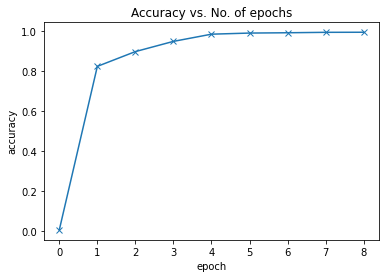

In [ ]:
plot_accuracies(history)

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

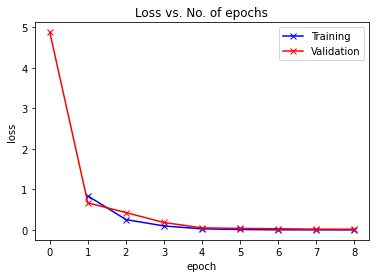

In [ ]:
plot_losses(history)

In [ ]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

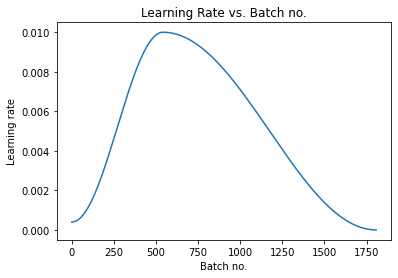

In [ ]:
plot_lrs(history)


## **Testing with individual images**

Now lets test our model on single image and see how it turns out.

In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return train_ds.classes[preds[0].item()]

Label: Apple Braeburn , Predicted: Apple Braeburn


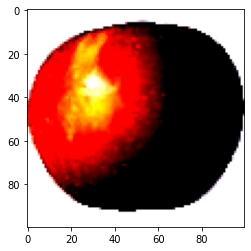

In [ ]:
img, label = valid_ds[0]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: Cactus fruit , Predicted: Cactus fruit


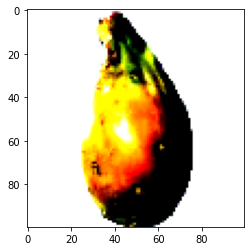

In [ ]:
img, label = valid_ds[3456]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: Cherry 2 , Predicted: Cherry 2


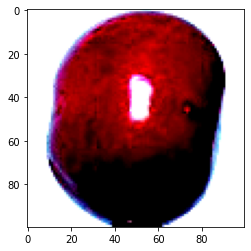

In [ ]:
img, label = valid_ds[4555]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: Apple Red 1 , Predicted: Apple Red 1


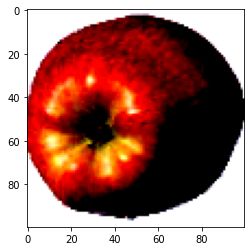

In [ ]:
img, label = valid_ds[1230]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: Grape White , Predicted: Grape White


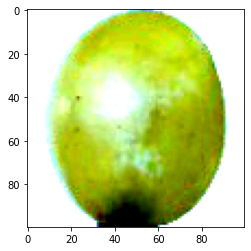

In [ ]:
img, label = valid_ds[7890]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: Lemon , Predicted: Lemon


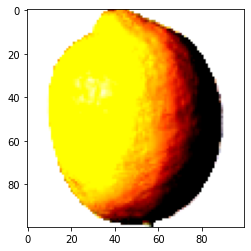

In [ ]:
img, label = valid_ds[9999]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

AWESOME!!! we are able to predict the images accurately  with our model.Now if you want to improve the speed you can try to train the model with differnt learning rates , batch size and architecture.

## **CONCLUSION** 

In this project we tried to create a convolutional neural network for the image classification of 131 types of fruits. The data is fairly large consisting of around 70000 images with 100*100 pixels.In the end we were able to create a model with almost 99.5% accuracy and we tested it out on some sample images ,now the model can be deployed.

Before concluding the notebook i would like to Thank Jovian platform for offering such an awesome course and for providing the guidance for completion of this project.

In [ ]:
!pip install jovian --upgrade --quiet

In [ ]:
import jovian

In [ ]:
torch.save(model.state_dict(), 'fruitscnn.pth')

In [ ]:
jovian.reset()
jovian.log_hyperparams(arch='resnet9', 
                       epochs=epochs, 
                       lr=max_lr, 
                       scheduler='one-cycle', 
                       weight_decay=weight_decay, 
                       grad_clip=grad_clip,
                       opt=opt_func.__name__)

[jovian] Hyperparams logged.


In [ ]:
jovian.log_metrics(val_loss=history[-1]['val_loss'], 
                   val_acc=history[-1]['val_acc'],
                   train_loss=history[-1]['train_loss'])
              

[jovian] Metrics logged.


In [ ]:
jovian.commit(project='01-imageclassication-of-fruits-usingcnn', environment=None, outputs=['fruitscnn.pth'])

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Uploading additional outputs...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/akashdominic3816/01-imageclassication-of-fruits-usingcnn


'https://jovian.ai/akashdominic3816/01-imageclassication-of-fruits-usingcnn'

In [ ]:
jovian.commit(project='01-imageclassication-of-fruits-usingcnn')

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Capturing environment..
[jovian] Committed successfully! https://jovian.ai/akashdominic3816/01-imageclassication-of-fruits-usingcnn


'https://jovian.ai/akashdominic3816/01-imageclassication-of-fruits-usingcnn'